In [44]:
import gnnco
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm.autonotebook import tqdm
import statistics

In [45]:
noise_levels = [0,0.02, 0.08, 0.12, 0.18, 0.24, 0.30]
avg_degrees = []
for noise in noise_levels:
    degrees = []
    dataset = gnnco.dataset.GMDataset(f"/scratch/jlagesse/gnnco/datasets/ER[100,24,{noise}]", validation=True)
    for (graph, _, _,_,_) in dataset:
        degrees.append(2*graph.size()/graph.order())
    avg_degrees.append(statistics.mean(degrees))
    


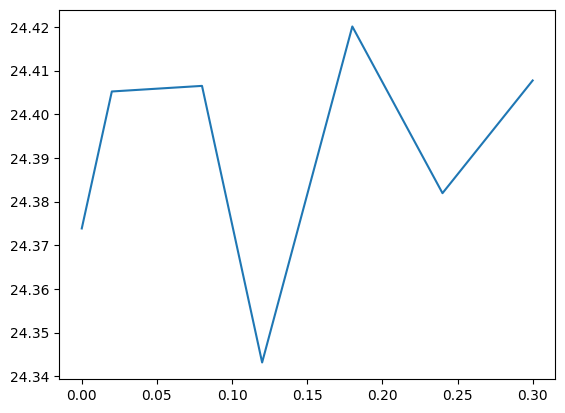

In [46]:
plt.plot(noise_levels, avg_degrees)

In [47]:
noise_levels = [0,0.02, 0.08, 0.12, 0.18, 0.24, 0.30]
avg_corr = []
for noise in noise_levels:
    corr = []
    dataset = gnnco.dataset.GMDataset(f"/scratch/jlagesse/gnnco/datasets/ER[100,24,{noise}]", validation=True)
    for (g1, g2, _,_,_) in dataset:
        g1 = g1.to_dense()._adj_matrix.float()
        g2 = g2.to_dense()._adj_matrix.float()
        res = (g1*g2).sum()/(torch.sqrt(g1.sum())*torch.sqrt(g2.sum()))
        corr.append(float(res))
    avg_corr.append(statistics.mean(corr))

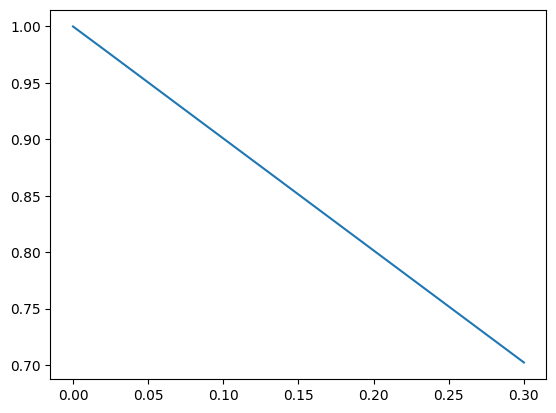

In [48]:
plt.plot(noise_levels, avg_corr)

In [49]:
noise_levels = [0,0.02, 0.08, 0.12, 0.18, 0.24, 0.30]
avg_corr = []
for noise in noise_levels:
    corr = []
    dataset = gnnco.dataset.GMDataset(f"/scratch/jlagesse/gnnco/datasets/ER[100,24,{noise}]", validation=True)
    for (g1, g2, _,_,_) in dataset:
        g1 = g1.to_dense()._adj_matrix.float()
        g2 = g2.to_dense()._adj_matrix.float()
        res = (g1*g2).sum()/(torch.sqrt(g1.sum())*torch.sqrt(g2.sum()))
        corr.append(float(res))
    avg_corr.append(statistics.mean(corr))

In [50]:
density = [2,4,8,16, 24, 32]
avg_size = []
for d in density:
    size = []
    dataset = gnnco.dataset.GMDataset(f"/scratch/jlagesse/gnnco/datasets/ER[100,{d},0]", validation=True)
    for (graph, _, _,_,_) in dataset:
        size.append(2*len(graph._senders)/2)
    avg_size.append(statistics.mean(size))

In [51]:
avg_size


[204.24, 409.396, 810.484, 1628.224, 2437.384, 3241.608]

In [14]:
from gnnco.random import erdos_renyi

In [19]:
batch = erdos_renyi(100, 100, 12/(100 -1), directed=True)

In [20]:
statistics.mean([adj.size() for adj in batch])

598.265

In [43]:
batch = torch.empty(size=(100, 10, 10), dtype=torch.bool).bernoulli_(9/(10 - 1))
print(batch.sum()/(100*10))
tri_up = batch.triu(-1)
print(tri_up.sum()/(100*10))
batch = tri_up | tri_up.transpose(1, 2)
print(batch.sum()/(100*10))

tensor(10.)
tensor(6.4000)
tensor(10.)


In [42]:
torch.ones((10,10)).triu(1).bool() | torch.ones((10,10)).triu(1).bool().T

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False]])

In [35]:
batch[0]

tensor([[ True,  True,  True, False, False, False, False,  True,  True, False],
        [ True,  True,  True,  True,  True,  True, False, False,  True,  True],
        [ True,  True, False, False, False, False, False, False, False,  True],
        [False,  True, False,  True, False, False,  True, False, False,  True],
        [False,  True, False, False, False, False, False,  True,  True,  True],
        [False,  True, False, False, False, False,  True, False, False, False],
        [False, False, False,  True, False,  True,  True,  True,  True,  True],
        [ True, False, False, False,  True, False,  True,  True,  True, False],
        [ True,  True, False, False,  True, False,  True,  True, False, False],
        [False,  True,  True,  True,  True, False,  True, False, False, False]])

In [33]:
statistics.mean([float(adj.sum()/100) for adj in batch])

12.327999982833862

In [52]:
import networkx


def generate_erdos_renyi_netx(p, N):
    """ Generate random Erdos Renyi graph """
    g = networkx.erdos_renyi_graph(N, p)
    W = networkx.adjacency_matrix(g).todense()
    return g, torch.as_tensor(W, dtype=torch.float), p

def noise_erdos_renyi(g, W, noise, edge_density):
    n_vertices = len(W)
    pe1 = noise
    pe2 = (edge_density*noise)/(1-edge_density)
    _,noise1,_ = generate_erdos_renyi_netx(pe1, n_vertices)
    _,noise2,_ = generate_erdos_renyi_netx(pe2, n_vertices)
    W_noise = W*(1-noise1) + (1-W)*noise2
    return W_noise

In [54]:
corr = []
for i in range(200):
    _,g1,_ = generate_erdos_renyi_netx(0.12, 100)
    g2 = noise_erdos_renyi(None, g1, 0.08, 0.12)
    res = (g1*g2).sum()/(torch.sqrt(g1.sum())*torch.sqrt(g2.sum()))
    corr.append(float(res))
print(statistics.mean(corr))

0.9199146747589111


In [64]:
def generate_pair(
    nb_graphs: int,
    n_nodes: int,
    edge_probability: float,
    perturbation_probability: float,
):
    directed_base = torch.empty(
            (nb_graphs, n_nodes, n_nodes), dtype=torch.int
        ).bernoulli_(p=edge_probability)
    base_triu = torch.triu(directed_base, diagonal=-1)
    base = base_triu + base_triu.transpose(1,2)

    noise1_directed = torch.empty(
            (nb_graphs, n_nodes, n_nodes), dtype=torch.int
        ).bernoulli_(p=perturbation_probability)
    noise1_triu = torch.triu(noise1_directed, diagonal=-1)
    noise1 = noise1_triu + noise1_triu.transpose(1,2)

    noise2_directed = torch.empty(
            (nb_graphs, n_nodes, n_nodes), dtype=torch.int
        ).bernoulli_(p=perturbation_probability*edge_probability/(1-edge_probability))
    noise2_triu = torch.triu(noise2_directed, diagonal=-1)
    noise2 = noise2_triu + noise2_triu.transpose(1,2)

    perturbated = base*(1-noise1) + (1-base)*noise2

    base = base.bool()
    perturbated = perturbated.bool()
    return base, perturbated

In [72]:
corr = []
for i in range(200):
    g1, g2 = generate_pair(1, 100, 0.12, 0.95)
    res = (g1*g2).sum()/(torch.sqrt(g1.sum())*torch.sqrt(g2.sum()))
    corr.append(float(res))
print(statistics.mean(corr))

0.08928021844476461
